In [1]:
import torch
import numpy as np
from model import cp_2_k_mask, cp_2_k_onnx
from config import args
from dataset import Enigma_simulate_c_2_p, Enigma_simulate_cp_2_k_limited, Enigma_simulate_cp_2_k
from torch.utils.data import DataLoader
import math
from torchsummary import summary
from tqdm import tqdm

Copying the compiled weight to regular models

In [2]:
# Load trained model's weights and config
ckpt = torch.load('CP2K_RNN_ENC_ckpt.pt')
ckpt_args = ckpt['args']

# Initialize new model by configs
model = cp_2_k_mask(args=ckpt_args, out_channels=26)
model.to('cuda')
model.eval()

# Load weights, calculate the number of parameters
weights = []
num_param = 0
for k, v in ckpt['weights'].items():
    weights.append(v)
    num_param += np.prod(v.shape)
print(f"Parameters: {num_param}")

# Copying weights from compile model to new model
for idx, (k, v) in enumerate(model.state_dict().items()):
    # We have to copying like this, I am so confused
    v *= 0
    v += weights[idx].detach()

# Set the model to evaluate mode
model.eval()

Parameters: 27408974


cp_2_k_mask(
  (networks): ModuleList(
    (0): RNN_encoder(
      (enc): LSTM(512, 512, num_layers=2, dropout=0.2, bidirectional=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (1): TransformerEncoder(
      (layers): ModuleList(
        (0-1): 2 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
          )
          (linear1): Linear(in_features=1024, out_features=2048, bias=True)
          (dropout): Dropout(p=0.2, inplace=False)
          (linear2): Linear(in_features=2048, out_features=1024, bias=True)
          (norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.2, inplace=False)
          (dropout2): Dropout(p=0.2, inplace=False)
        )
      )
    )
  )
  (linear_projectors): Linear(in_features=1024, out_features=78, bia

Running a mini batch of examples

In [3]:
dataset = Enigma_simulate_cp_2_k_limited(args=args)
dataloader = DataLoader(
        dataset=dataset,
        batch_size=512,
        collate_fn=dataset.collate_fn_padding,
        shuffle=True
    )

data_iter = iter(dataloader)
inputs, targets, masks = next(data_iter)
inputs, targets, masks = inputs.to('cuda'), targets.to('cuda'), masks.to('cuda')

outputs = model(inputs, masks)

print(f"Input shape: {inputs.shape} {'[seq, batch, feats]'}\n"
          f"Target shape: {targets.shape}  {'[rotor, seq, batch]'}\n"
          f"Mask shape: {masks.shape}  {'[batch, seq]'}\n"
          f"Output shape: {outputs.shape}  {'[rotor, seq, batch, feats]'}")

true_positive = 0
samples = 0

outputs_indices = torch.argmax(outputs, dim=-1) # -> [rotor, seq, batch]
for rotor in range(outputs_indices.shape[0]):
    mask = outputs_indices[rotor][~masks.T] == targets[rotor][~masks.T]
    true_positive += mask.sum()
    samples += math.prod(mask.shape)

print(f"Acc: {true_positive / samples}")

Input shape: torch.Size([30, 512, 52]) [seq, batch, feats]
Target shape: torch.Size([3, 30, 512])  [rotor, seq, batch]
Mask shape: torch.Size([512, 30])  [batch, seq]
Output shape: torch.Size([3, 30, 512, 26])  [rotor, seq, batch, feats]
Acc: 0.9993489980697632


In [4]:
# Make prediction based on user's inputs( Results should be "AES")
from dataset import cipher_plain_text_2_tensor
inputs, masks = cipher_plain_text_2_tensor('VMPDTAJYTXDZNEFOSOTPJOYSMO', 'WEARETHECHAMPIONANDTHEBEST') # Predict on usr inputs
inputs, masks = inputs.to('cuda'), masks.to('cuda')


# Make prediction
with torch.no_grad():
    outputs = model(inputs, masks).argmax(dim=-1).squeeze(-1) # -> shape [rotor, seq]

# print the prediction at the first postion, which is the initial states
print(f"Prediction: {chr(ord('A') + outputs[0, 0])}"
      f"{chr(ord('A') + outputs[1, 0])}"
      f"{chr(ord('A') + outputs[2, 0])}")

Prediction: AES


In [5]:
# Transfer to onnx
import onnx, onnxruntime
onnx_model = cp_2_k_onnx(args=ckpt_args, out_channels=26)
onnx_model.to('cuda')
onnx_model.eval()

# Load weights, calculate the number of parameters
weights = []
num_param = 0
for k, v in ckpt['weights'].items():
    weights.append(v)
    num_param += np.prod(v.shape)
print(f"Parameters: {num_param}")

# Copying weights from compile model to new model
for idx, (k, v) in enumerate(onnx_model.state_dict().items()):
    # We have to copying like this, I am so confused
    v *= 0
    v += weights[idx].detach()

# Testing the pre-export model in batch size 1
dataloader = DataLoader(
        dataset=dataset,
        batch_size=1,
        collate_fn=dataset.collate_fn_padding,
        shuffle=True
    )

# Get samples for dataset
data_iter = iter(dataloader)
inputs, targets, masks = next(data_iter)
inputs, targets, masks = inputs.to('cuda'), targets.to('cuda'), masks.to('cuda')

outputs = onnx_model(inputs)

print(f"Input shape: {inputs.shape} {'[seq, batch, feats]'}\n"
      f"Target shape: {targets.shape}  {'[rotor, seq, batch]'}\n"
      f"Mask shape: {masks.shape}  {'[batch, seq]'}\n"
      f"Output shape: {outputs.shape}  {'[rotor, seq, batch, feats]'}")


true_positive = 0
samples = 0

outputs_indices = torch.argmax(outputs, dim=-1) # -> [rotor, seq, batch]
for rotor in range(outputs_indices.shape[0]):
    mask = outputs_indices[rotor][~masks.T] == targets[rotor][~masks.T]
    true_positive += mask.sum()
    samples += math.prod(mask.shape)

print(f"Acc: {true_positive / samples}")

# Export onnx model
torch.onnx.export(
    onnx_model,
    args=inputs,
    f="seq5-45-large.onnx",
    input_names=["input_1"],
    output_names=["output1"]
)

# Load and verify onnx model
ort_session = onnxruntime.InferenceSession("seq5-45-large.onnx")
inputs, _ = cipher_plain_text_2_tensor('WEARETHECHAMPIONANDTHEBESTPLAY', 'VMPDTAJYTXDZNEFOSOTPJOYSMOEBNX')
outputs = ort_session.run(
    None,
    {"input_1": np.array(inputs)},
)

outputs = outputs[0].argmax(axis=-1).reshape(outputs[0].shape[0], outputs[0].shape[1])
print(outputs.shape)
print(f"Onnx Prediction: {chr(ord('A') + outputs[0, 0])}"
      f"{chr(ord('A') + outputs[1, 0])}"
      f"{chr(ord('A') + outputs[2, 0])}")


Parameters: 27408974
Input shape: torch.Size([30, 1, 52]) [seq, batch, feats]
Target shape: torch.Size([3, 30, 1])  [rotor, seq, batch]
Mask shape: torch.Size([1, 30])  [batch, seq]
Output shape: torch.Size([3, 30, 1, 26])  [rotor, seq, batch, feats]
Acc: 1.0


C:\Users\83577\anaconda3\envs\torch\lib\site-packages\torch\onnx\symbolic_opset9.py:4476: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with LSTM can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn(


============= Diagnostic Run torch.onnx.export version 2.0.1+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 1 ERROR ========================
ERROR: missing-standard-symbolic-function
Exporting the operator 'aten::unflatten' to ONNX opset version 14 is not supported. Please feel free to request support or submit a pull request on PyTorch GitHub: https://github.com/pytorch/pytorch/issues.
None
<Set verbose=True to see more details>




UnsupportedOperatorError: Exporting the operator 'aten::unflatten' to ONNX opset version 14 is not supported. Please feel free to request support or submit a pull request on PyTorch GitHub: https://github.com/pytorch/pytorch/issues.

In [6]:
# Testint accuracy in different length
testing_args = args
results = {}


for length in range(5, 51):
    testing_args['SEQ_LENGTH'] = [length, length]
    dataset = Enigma_simulate_cp_2_k_limited(args=testing_args, mode='test')
    dataloader = DataLoader(
        dataset=dataset,
        batch_size=1024,
        collate_fn=dataset.collate_fn_padding,
        shuffle=False,
        drop_last=False
    )

    # Tracking
    true_positive = 0
    samples = 0

    bar = tqdm(dataloader, leave=True)
    bar.set_description_str(f"Length: {length}")

    for inputs, targets, masks in bar:
        inputs, targets, masks = inputs.to('cuda'), targets.to('cuda'), masks.to('cuda')

        # Making prediction
        # with torch.cuda.amp.autocast():
        with torch.no_grad():
            outputs = model(inputs, masks)

            # Compute accuracy
            outputs_indices = torch.argmax(outputs, dim=-1) # -> [rotor, seq, batch]
            for rotor in range(outputs_indices.shape[0]):
                mask = outputs_indices[rotor][~masks.T] == targets[rotor][~masks.T]
                true_positive += mask.sum()
                samples += math.prod(mask.shape)

        # Set bar's postfix
        bar.set_postfix_str(f"Acc: {(true_positive / samples).item()}")

    # Output and record the result
    results[length] = (true_positive / samples).item()

Length: 50: 100%|██████████| 35/35 [00:18<00:00,  1.88it/s, Acc: 0.9848829507827759]


Ploting the results

[ 5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28
 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50] [0.12045592 0.18985642 0.30232379 0.45203215 0.60563749 0.72905856
 0.81604993 0.87776887 0.91757476 0.94599169 0.96698278 0.98045039
 0.98758835 0.99204826 0.99361867 0.99537247 0.99639165 0.99704611
 0.99741244 0.99773681 0.99813038 0.99836022 0.9987514  0.99893725
 0.99902099 0.99909222 0.99911141 0.99916381 0.99918562 0.99921876
 0.99925143 0.99926031 0.99928528 0.99931347 0.99932581 0.99934471
 0.99935842 0.99937618 0.99939293 0.99940622 0.99942368 0.99938053
 0.99731237 0.99794775 0.99501991 0.98488295]


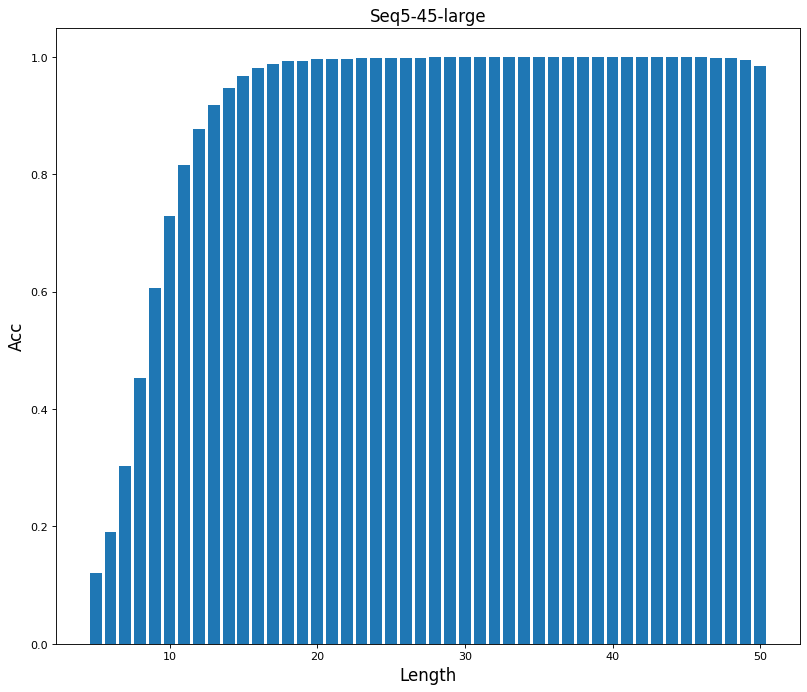

In [7]:
import matplotlib.pyplot as plt


x = list(results.keys())
y = list(results.values())

x, y = np.array(x), np.array(y)
print(x, y)

fig, ax = plt.subplots(figsize=(12, 10), dpi=80)
ax.bar(x,height=y)
plt.title('Seq5-45-large', fontsize=15)
ax.set_ylabel('Acc', fontsize=15)
ax.set_xlabel('Length', fontsize=15)
plt.show()
# ax.plot(bins, y, '--')